In [29]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [30]:
def read_data(url):
    df = pd.read_csv(url)
    df = df.loc[df[" utilization.gpu [%]"] > 0] #isolating training 
    #print(df.columns)
    return df

In [31]:
def time_duration(df):
    df.timestamp = [datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in df.timestamp]
    time_interval = df.iloc[-1].timestamp - df.iloc[0].timestamp
    #print("Total time in seconds: {}".format(time_interval.total_seconds()))
    return time_interval.total_seconds()

In [32]:
def power_reading(url):
    df = read_data(url)
    time_interval = time_duration(df)
    df_gpu1 = df.iloc[::2]
    df_gpu2 = df.iloc[1::2]
    mean_power = df[' power.draw [W]'].mean() # refer notebook on time series
    total_power = mean_power * time_interval * 2 / (1000 *60*60)
    gpu1_mean = df_gpu1[' power.draw [W]'].mean()
    gpu2_mean = df_gpu2[' power.draw [W]'].mean()
    gpu1_util = df_gpu1[' utilization.gpu [%]'].mean()
    gpu2_util = df_gpu2[' utilization.gpu [%]'].mean()
    gpu_util = (gpu1_util + gpu2_util) / 2
    memory_util = df[' utilization.memory [%]'].mean()
    memory_used = df[' memory.used [MiB]'].mean()
    extract = url.split('/')[1].replace(".","_").split('_')
    end_time = df.iloc[-1].timestamp
    start_time = df.iloc[0].timestamp
    data = []
    if (extract[2] != 'pretrain'):
        data = [extract[2], extract[3], extract[4],
                mean_power,time_interval,total_power,gpu_util,
                gpu1_util,gpu2_util,gpu1_mean,gpu2_mean,
                memory_util,memory_used, start_time, end_time]
#     else:
#         data = [extract[2], None, None,
#                 mean_power,time_interval,total_power,gpu_util,memory_util,memory_used]
    return df, data

In [33]:
import os
folder_name = 'nvidia'
result = pd.DataFrame(columns=['dataset','batchsize','max_seq_len',
                               'mean_power','total_time','power','gpu_util',
                               'gpu1_util','gpu2_util','gpu1_mean_power','gpu2_mean_power',
                               'memory_util','memory_used',
                               'start_time','end_time'])

for file_name in os.listdir(folder_name):
    #print(file_name)
    url = folder_name + '/' + file_name
    df,data = power_reading(url)
   # print (data)
    if data:
        result =result.append(pd.Series(data, index=result.columns),ignore_index=True)
    #print ("-------------------------------------------")

In [34]:
train_dataset_sizes = {
    'MRPC':3668,
    'CoLA': 8551,
    'SST-2':67349,
    'MNLI':392702,
    'STS-B':8628
}

In [35]:
result['dataset_size'] = result['dataset']
result["dataset_size"].replace(train_dataset_sizes, inplace=True)

In [36]:
result[["batchsize","max_seq_len"]] = result[["batchsize","max_seq_len"]].apply(pd.to_numeric)
result["total_batchsize"] = result["batchsize"] * 2
result["samples_per_sec"] = (result["dataset_size"] * 3) / result.total_time #3 epochs
result["time_per_sample"] = result.total_time /(result["dataset_size"] * 3)
result

,dataset,batchsize,max_seq_len,mean_power,total_time,power,gpu_util,gpu1_util,gpu2_util,gpu1_mean_power,gpu2_mean_power,memory_util,memory_used,start_time,end_time,dataset_size,total_batchsize,samples_per_sec,time_per_sample
0,SST-2,16,256,211.759289,493.516,0.058059,93.375404,91.858025,94.892784,209.406523,214.116907,38.238929,6151.259526,2020-06-13 15:58:07.779,2020-06-13 16:06:21.295,67349,32,409.403140,0.002443
1,MRPC,28,128,204.860397,77.174,0.008783,91.133070,86.039474,96.226667,200.702500,209.073733,34.264901,4803.768212,2020-06-13 20:27:00.615,2020-06-13 20:28:17.789,3668,56,142.586882,0.007013
2,SST-2,56,128,222.548349,1151.970,0.142427,95.185412,95.451642,94.919183,222.648004,222.448606,39.189525,7789.496671,2020-06-15 01:11:57.344,2020-06-15 01:31:09.314,67349,112,175.392588,0.005701
3,SST-2,24,128,207.307071,1518.205,0.174853,91.829979,89.663313,93.996644,204.863213,209.752570,32.549145,4523.066756,2020-06-15 00:03:01.213,2020-06-15 00:28:19.418,67349,48,133.082818,0.007514
4,MRPC,20,128,193.060506,90.725,0.009731,90.129213,85.404494,94.853933,186.631124,199.489888,31.393258,4050.230337,2020-06-13 20:18:29.390,2020-06-13 20:20:00.115,3668,40,121.289611,0.008245
5,CoLA,32,256,227.781566,311.942,0.039475,95.155207,94.013029,96.297386,223.631010,231.945686,42.350734,10323.463295,2020-06-12 15:12:46.791,2020-06-12 15:17:58.733,8551,64,82.236441,0.012160
6,MRPC,16,128,166.462923,98.801,0.009137,90.383547,84.591837,96.175258,162.022653,170.948969,30.579487,3563.138462,2020-06-11 11:40:50.391,2020-06-11 11:42:29.192,3668,32,111.375391,0.008979
7,MRPC,64,128,223.450000,55.178,0.006850,97.333333,98.833333,95.833333,225.560833,221.339167,41.041667,8502.500000,2020-06-10 17:21:12.948,2020-06-10 17:22:08.126,3668,128,199.427308,0.005014
8,MRPC,32,128,199.650667,70.170,0.007783,92.533333,97.933333,87.133333,202.284000,197.017333,33.366667,5261.500000,2020-06-10 16:29:43.812,2020-06-10 16:30:53.982,3668,64,156.819153,0.006377
9,MRPC,40,128,215.501631,71.807,0.008597,92.079276,93.901408,90.257143,217.283521,213.694286,36.510638,6020.312057,2020-06-13 20:37:13.270,2020-06-13 20:38:25.077,3668,80,153.244113,0.006526


In [37]:
import time
result_file = "results/result"+ str(int(time.time()))+".csv"
result.to_csv(result_file, index=False)

In [23]:
df_mrpc = result.loc[(result.dataset == 'MRPC') & (result.max_seq_len == 128)]

In [24]:
df_mrpc =df_mrpc.sort_values('batchsize')

In [25]:
df_mrpc

,dataset,batchsize,max_seq_len,mean_power,total_time,power,gpu_util,gpu1_util,gpu2_util,gpu1_mean,gpu2_mean,memory_util,memory_used,start_time,end_time,dataset_size,total_batchsize,samples_per_sec,time_per_sample
6,MRPC,16,128,166.462923,98.801,0.009137,90.383547,84.591837,96.175258,162.022653,170.948969,30.579487,3563.138462,2020-06-11 11:40:50.391,2020-06-11 11:42:29.192,3668,32,111.375391,0.008979
4,MRPC,20,128,193.060506,90.725,0.009731,90.129213,85.404494,94.853933,186.631124,199.489888,31.393258,4050.230337,2020-06-13 20:18:29.390,2020-06-13 20:20:00.115,3668,40,121.289611,0.008245
25,MRPC,24,128,208.408171,83.879,0.009712,91.000000,86.926829,95.073171,203.617683,213.198659,33.286585,4435.317073,2020-06-13 20:24:49.507,2020-06-13 20:26:13.386,3668,48,131.188975,0.007623
1,MRPC,28,128,204.860397,77.174,0.008783,91.133070,86.039474,96.226667,200.702500,209.073733,34.264901,4803.768212,2020-06-13 20:27:00.615,2020-06-13 20:28:17.789,3668,56,142.586882,0.007013
8,MRPC,32,128,199.650667,70.170,0.007783,92.533333,97.933333,87.133333,202.284000,197.017333,33.366667,5261.500000,2020-06-10 16:29:43.812,2020-06-10 16:30:53.982,3668,64,156.819153,0.006377
9,MRPC,40,128,215.501631,71.807,0.008597,92.079276,93.901408,90.257143,217.283521,213.694286,36.510638,6020.312057,2020-06-13 20:37:13.270,2020-06-13 20:38:25.077,3668,80,153.244113,0.006526
13,MRPC,48,128,222.867895,67.682,0.008380,93.821574,90.552239,97.090909,219.555821,226.230152,37.819549,6779.187970,2020-06-13 20:51:52.487,2020-06-13 20:53:00.169,3668,96,162.583848,0.006151
24,MRPC,56,128,229.412460,63.976,0.008154,92.515873,95.507937,89.523810,230.389524,228.435397,37.920635,7569.753968,2020-06-14 23:56:04.578,2020-06-14 23:57:08.554,3668,112,172.002001,0.005814
7,MRPC,64,128,223.450000,55.178,0.006850,97.333333,98.833333,95.833333,225.560833,221.339167,41.041667,8502.500000,2020-06-10 17:21:12.948,2020-06-10 17:22:08.126,3668,128,199.427308,0.005014


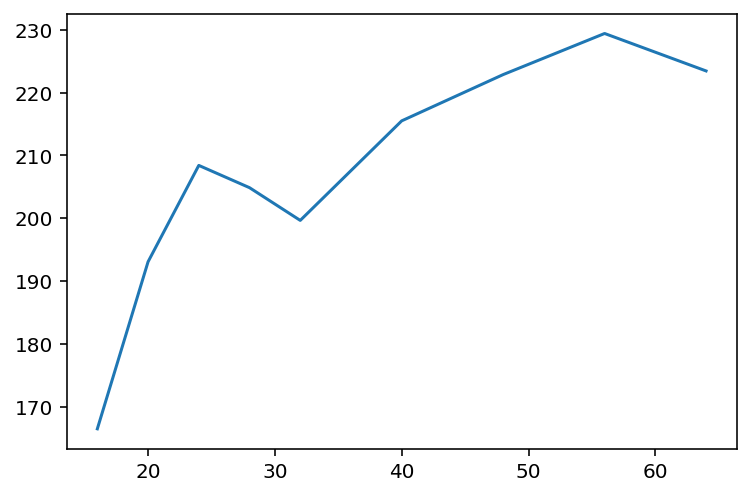

In [27]:
fig, ax = plt.subplots()
ax = plt.plot(df_mrpc['batchsize'],df_mrpc["mean_power"])

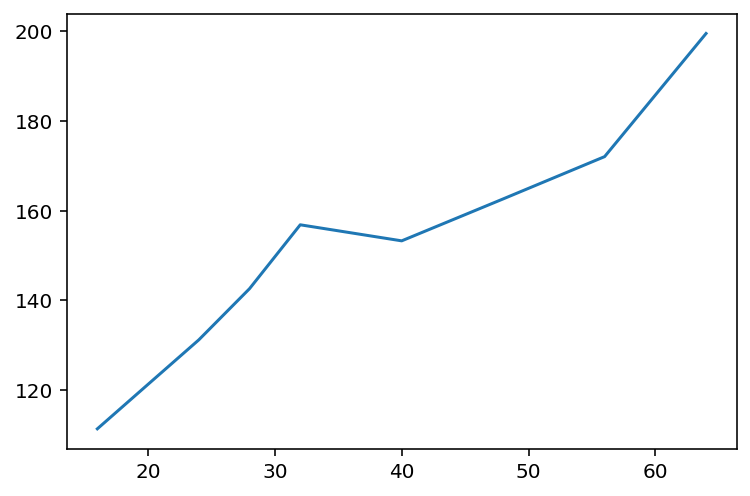

In [28]:
ax = plt.plot(df_mrpc['batchsize'],df_mrpc["samples_per_sec"])

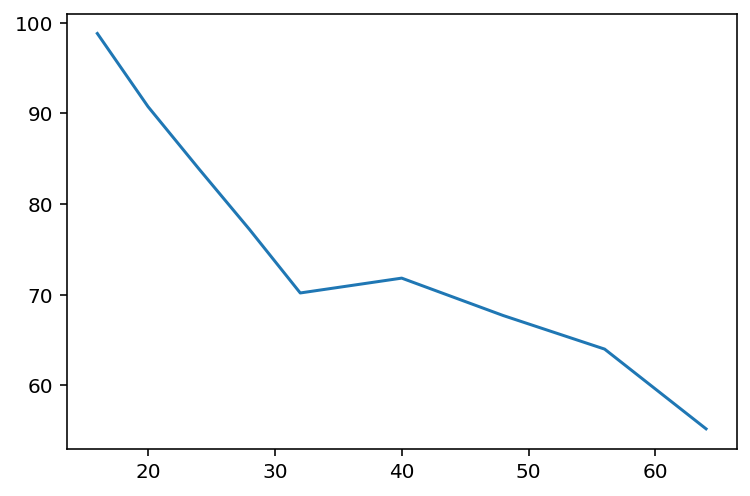

In [52]:
ax = plt.plot(df_mrpc['batchsize'],df_mrpc["total_time"])

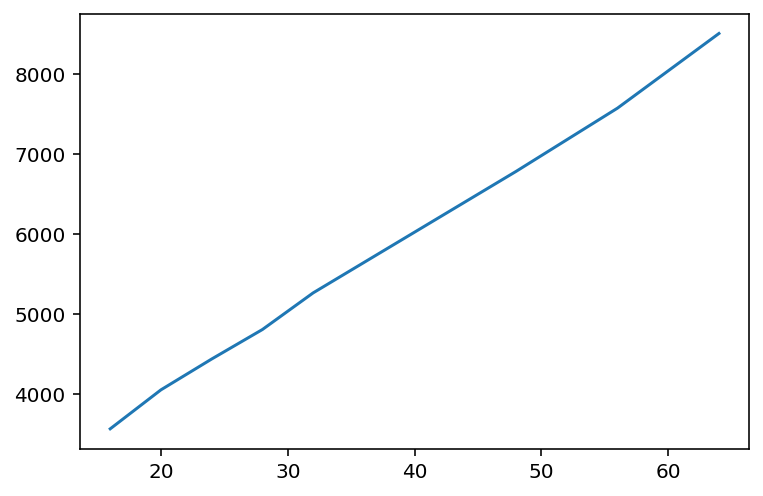

In [53]:
ax = plt.plot(df_mrpc['batchsize'],df_mrpc["memory_used"])

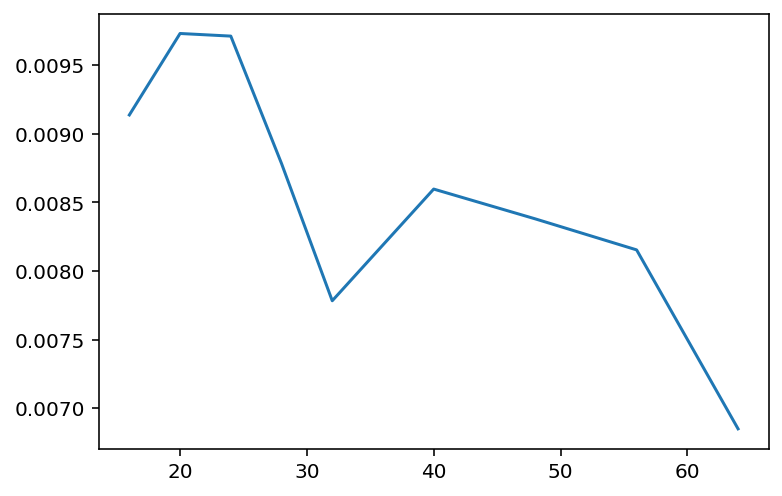

In [55]:
ax = plt.plot(df_mrpc['batchsize'],df_mrpc["power"])

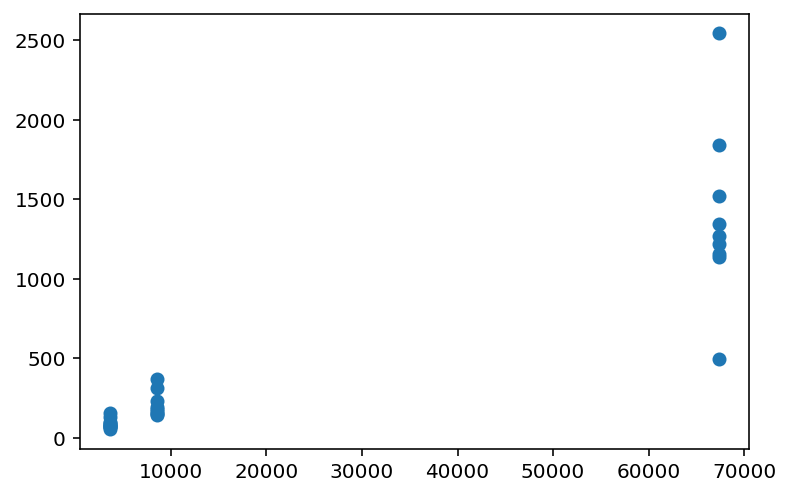

In [42]:
ax = plt.scatter(result['dataset_size'],result["total_time"])

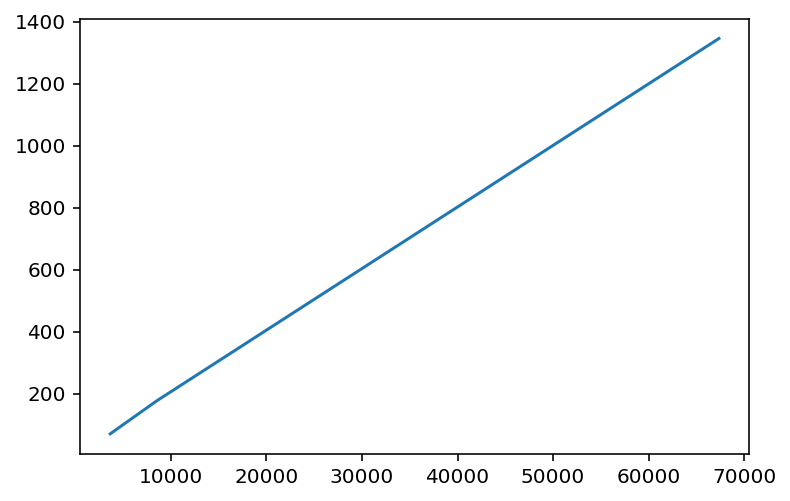

In [46]:
subset_32_128 = result.loc[(result.batchsize == 32) & (result.max_seq_len == 128)]
subset_32_128 = subset_32_128.sort_values('dataset_size')
plt.plot(subset_32_128['dataset_size'],subset_32_128["total_time"])

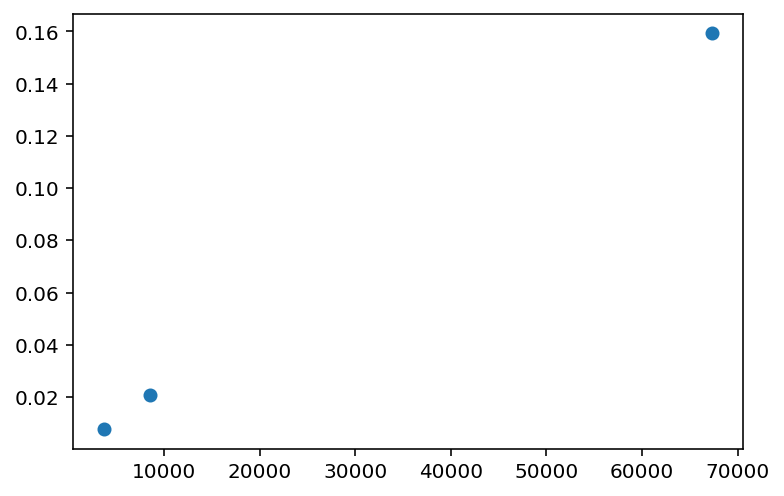

In [48]:
plt.scatter(subset_32_128['dataset_size'],subset_32_128["power"])

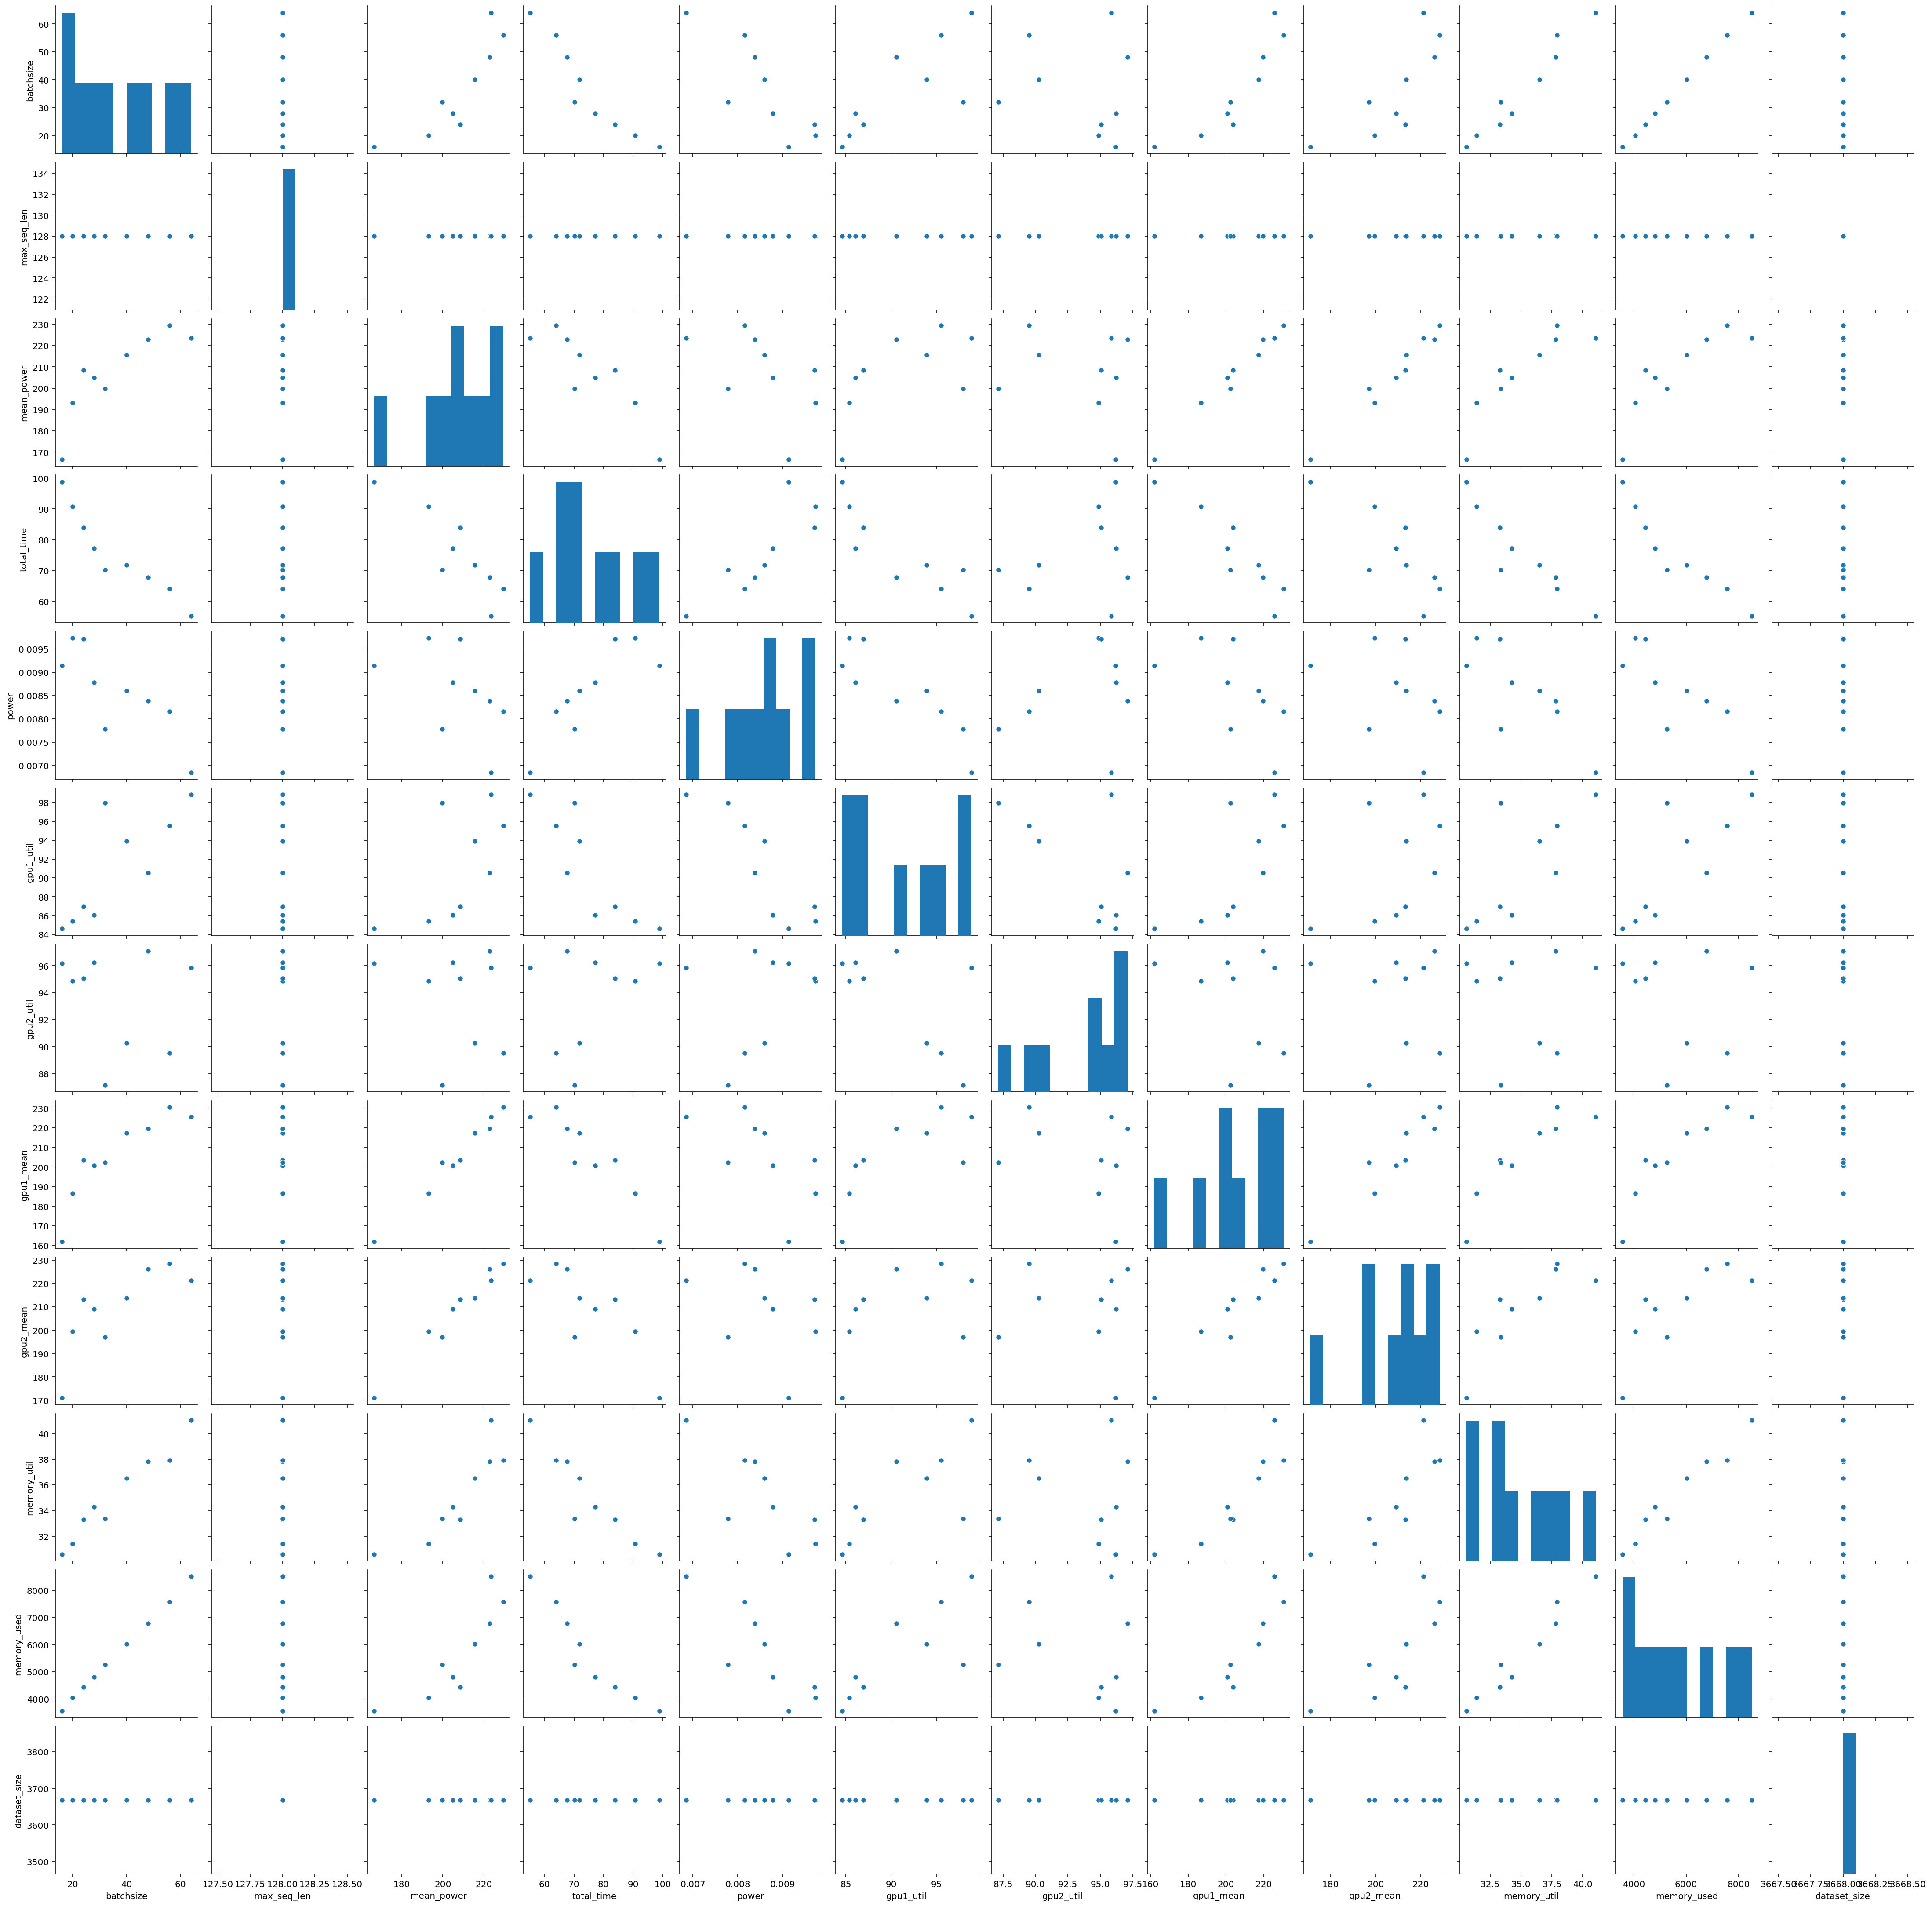

In [54]:
sns.pairplot(df_mrpc)

Increasing batch size leads to less time, better gpu util, more memory used.

Urrgghh but I knew that!


## regression model to predict time, power, gpu util, memory util

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, ShuffleSplit

In [73]:
models = dict(
    linear_reg=LinearRegression(normalize=True),
    random_forest = RandomForestRegressor(random_state=1),
    xgboost=XGBRegressor(random_state=1)
)

In [77]:
def run_models_cv(result):
    features = ['batchsize','max_seq_len','dataset_size']
    X = result[features]
    targets = ['mean_power','total_time','gpu_util','memory_util']
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
    for target in targets:
        y = result[target]
        #print ("________{}_________".format(target))
        
        for name, model in models.items():
            #print(name)
            scores = cross_val_score(model, X, y, cv=cv)
            yield target, name, scores

In [78]:
# features = ['batchsize','max_seq_len','dataset_size']
# X = result[features]
# y = result['mean_power']
# cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
# linear_reg=LinearRegression(normalize=True)
# scores = cross_val_score(linear_reg, X, y, cv=cv)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [79]:
df_cv = pd.DataFrame(columns=("target", "model","score","std"))
for target, name, scores in run_models_cv(result):
    score_result = dict(target=target,
                       model=name,
                       score=scores.mean(),
                       std=scores.std() * 2)
    df_cv = df_cv.append(score_result,ignore_index=True)
df_cv.to_csv('results/run_models_results.csv', index=False)
df_cv

,target,model,score,std
0,mean_power,linear_reg,0.575713,0.551988
1,mean_power,random_forest,0.559372,0.214537
2,mean_power,xgboost,0.555027,0.369279
3,total_time,linear_reg,-3.172735,16.436866
4,total_time,random_forest,-3.251660,16.583754
5,total_time,xgboost,-5.657245,25.620449
6,gpu_util,linear_reg,0.647745,0.195122
7,gpu_util,random_forest,0.554077,0.410059
8,gpu_util,xgboost,0.262363,1.196223
9,memory_util,linear_reg,0.880297,0.129637


Time cannot be predicted with the indicators we are using.

A pretty good indication of memory utiliation. Can almost predit gpu util and power consumption.

In [80]:
def run_models_kfold(result):
    features = ['batchsize','max_seq_len','dataset_size']
    X = result[features]
    targets = ['mean_power','total_time','gpu_util','memory_util']
    kf = KFold(n_splits=3, shuffle=True, random_state=1)
    
    for target in targets:
        y = result[target]
        #print ("________{}_________".format(target))
        fold_id = 0
        for train_index, test_index in kf.split(X):
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            for name, model in models.items():
                #print(name)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                r2 = r2_score(y_test, y_pred)
                mae = mean_absolute_error(y_test, y_pred)
                mse = mean_squared_error(y_test, y_pred)
                yield fold_id, target, name, r2, mae, sqrt(mse)
            fold_id += 1

In [81]:
df_models = pd.DataFrame(columns=('fold_id','target','model_name','r2','mean_abs_error','root_mean_sqr_error'))

In [82]:
for fold_id, target, name, r2, mae, rmse in run_models_kfold(result):
    model_result = dict(fold_id=fold_id,
                        target=target,
                        model_name=name,
                        r2=r2,
                        mean_abs_error=mae,
                        root_mean_sqr_error=rmse)
    #print(model_result)
    df_models = df_models.append(model_result,ignore_index=True)


In [83]:
df_models

,fold_id,target,model_name,r2,mean_abs_error,root_mean_sqr_error
0,0,mean_power,linear_reg,0.644963,7.204547,8.838259
1,0,mean_power,random_forest,0.624146,6.462525,9.093680
2,0,mean_power,xgboost,0.634857,6.261387,8.963171
3,1,mean_power,linear_reg,0.657161,8.164857,11.564782
4,1,mean_power,random_forest,0.506018,10.570125,13.881865
5,1,mean_power,xgboost,0.452974,11.799270,14.608186
6,2,mean_power,linear_reg,0.638176,6.774865,8.917388
7,2,mean_power,random_forest,0.412036,7.515732,11.367488
8,2,mean_power,xgboost,0.316577,8.370233,12.255581
9,0,total_time,linear_reg,0.341178,430.241765,641.800214


In [84]:
xgboost=XGBRegressor(random_state=1)
features = ['batchsize','max_seq_len','dataset_size']
X = result[features]
y = result['mean_power']
xgboost.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [85]:
def feature_imp(model, train_X):
    feature_importances = pd.DataFrame(model.feature_importances_,
    index = train_X.columns,
    columns=['importance']).sort_values('importance', ascending=False)
    sns.barplot(data=feature_importances.reset_index(),x='importance',y='index',orient='h')

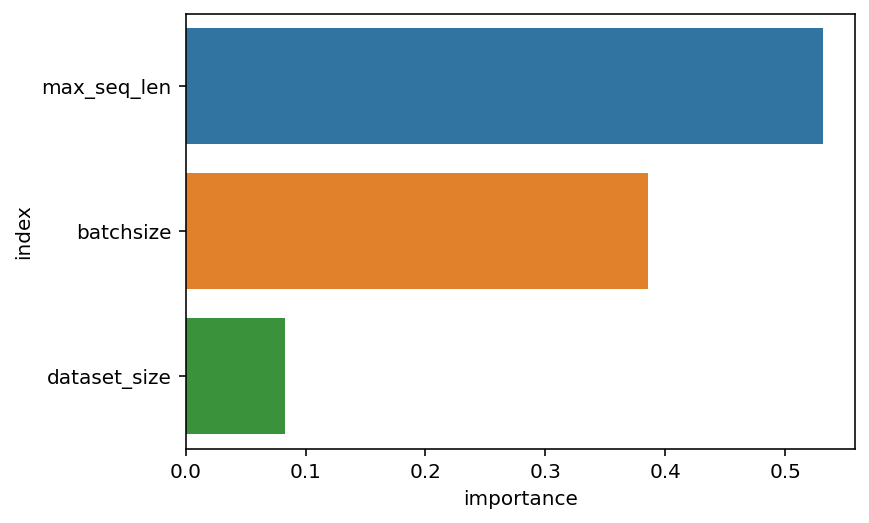

In [86]:
feature_imp(xgboost,X)

In [91]:
forest_model=RandomForestRegressor(random_state=1)
features = ['batchsize','max_seq_len','dataset_size']
X = result[features]
y = result['mean_power']
forest_model.fit(X,y)

RandomForestRegressor(random_state=1)

In [92]:
forest_model.predict([[30,128,3668]])

array([205.65461492])

In [93]:
forest_model.predict([[50,128,3668]])

array([223.59195963])

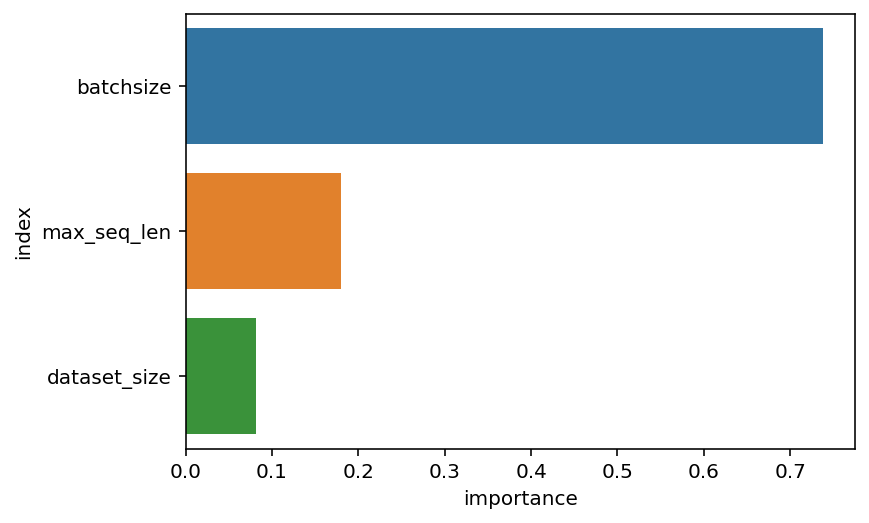

In [94]:
feature_imp(forest_model,X)

In [43]:
url = 'nvidia/nvidia_power_CoLA_32_128.csv'
df, x= power_reading(url)

In [44]:
df.columns

Index(['timestamp', ' utilization.gpu [%]', ' utilization.memory [%]',
       ' memory.total [MiB]', ' memory.used [MiB]', ' memory.free [MiB]',
       ' temperature.gpu', ' power.draw [W]', ' pstate'],
      dtype='object')

In [119]:
#sns.pairplot(df)